In [93]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from pathlib import Path
from torchvision.ops import nms

In [16]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=125):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

### Load Model

In [17]:
device = torch.device('cuda:4')

processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14")
model.eval;
model.to(device);

### Detect Objects

In [84]:
n = 0

In [89]:
# image_path = "/data/mwoedlinger/code/sustainibility-hackathon/sample_data2/data/image0000004.jpg"
# image_path = "/data/mwoedlinger/code/download-removebg-preview.png"
# image_path = "/data/mwoedlinger/code/image19-removebg-preview.png"
# image_path = "/data/mburges/for_matthias/images_hackathon/image19.jpg"
images = [img for img in Path('/data/mburges/for_matthias/images_hackathon').iterdir()]

# Load image
image_path = images[n]
image = Image.open(image_path).convert("RGB")

texts = [["object", "can", "bottle"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

n += 1

Detected can with confidence 0.141 at location [1133.07, 3.24, 1499.39, 384.86]
Detected can with confidence 0.466 at location [1135.22, 10.69, 1501.15, 389.79]
Detected can with confidence 0.438 at location [1427.14, 28.04, 1835.9, 416.17]
Detected bottle with confidence 0.453 at location [-11.23, -11.22, 342.5, 413.72]
Detected can with confidence 0.151 at location [1135.95, 6.8, 1922.46, 552.04]
Detected object with confidence 0.133 at location [1644.44, 195.83, 1927.19, 543.33]
Detected can with confidence 0.317 at location [1637.37, 205.45, 1923.78, 545.79]
Detected object with confidence 0.157 at location [11.85, 105.48, 1927.46, 1206.63]
Detected object with confidence 0.319 at location [545.22, 583.21, 1103.59, 1127.53]
Detected object with confidence 0.1 at location [1496.83, 789.2, 1927.14, 1194.8]
Detected object with confidence 0.139 at location [1489.77, 787.9, 1930.12, 1196.43]
Detected bottle with confidence 0.303 at location [1485.75, 785.09, 1924.18, 1203.11]


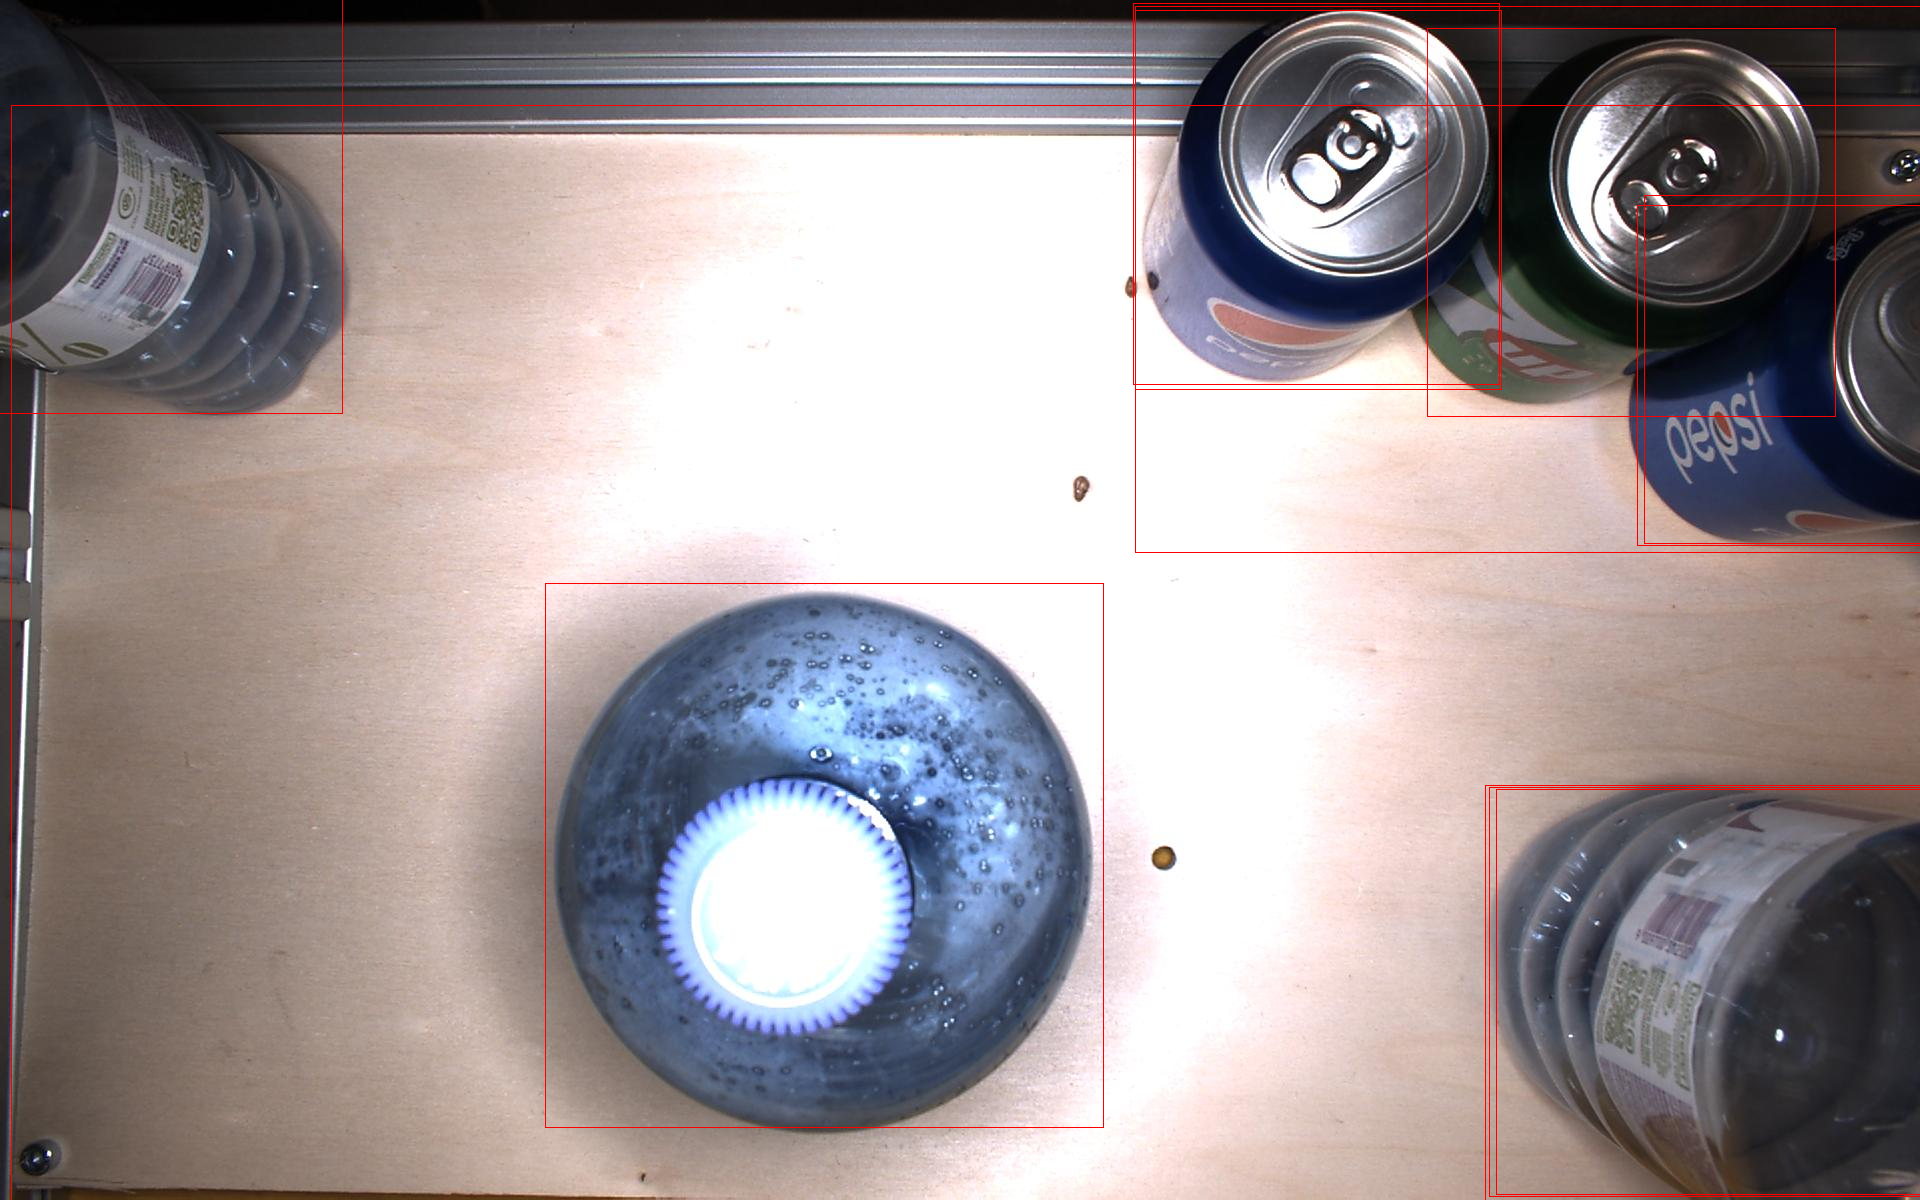

In [90]:
with torch.no_grad():
    outputs = model(**inputs.to(device))
    
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]]).to(device)
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
        
# visualize results with pillow
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.1:
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])), outline="red")
        #draw.text((boxes[i][0], boxes[i][1]), str(labels[i]) + " " + str(scores[i]), fill="red")
image.show()

### Non-maximum suppression

In [96]:
boxes_filtered = boxes[scores > 0.1]
scores_filtered = scores[scores > 0.1]

In [97]:
nms_out = nms(boxes_filtered, scores_filtered, iou_threshold=0.5)

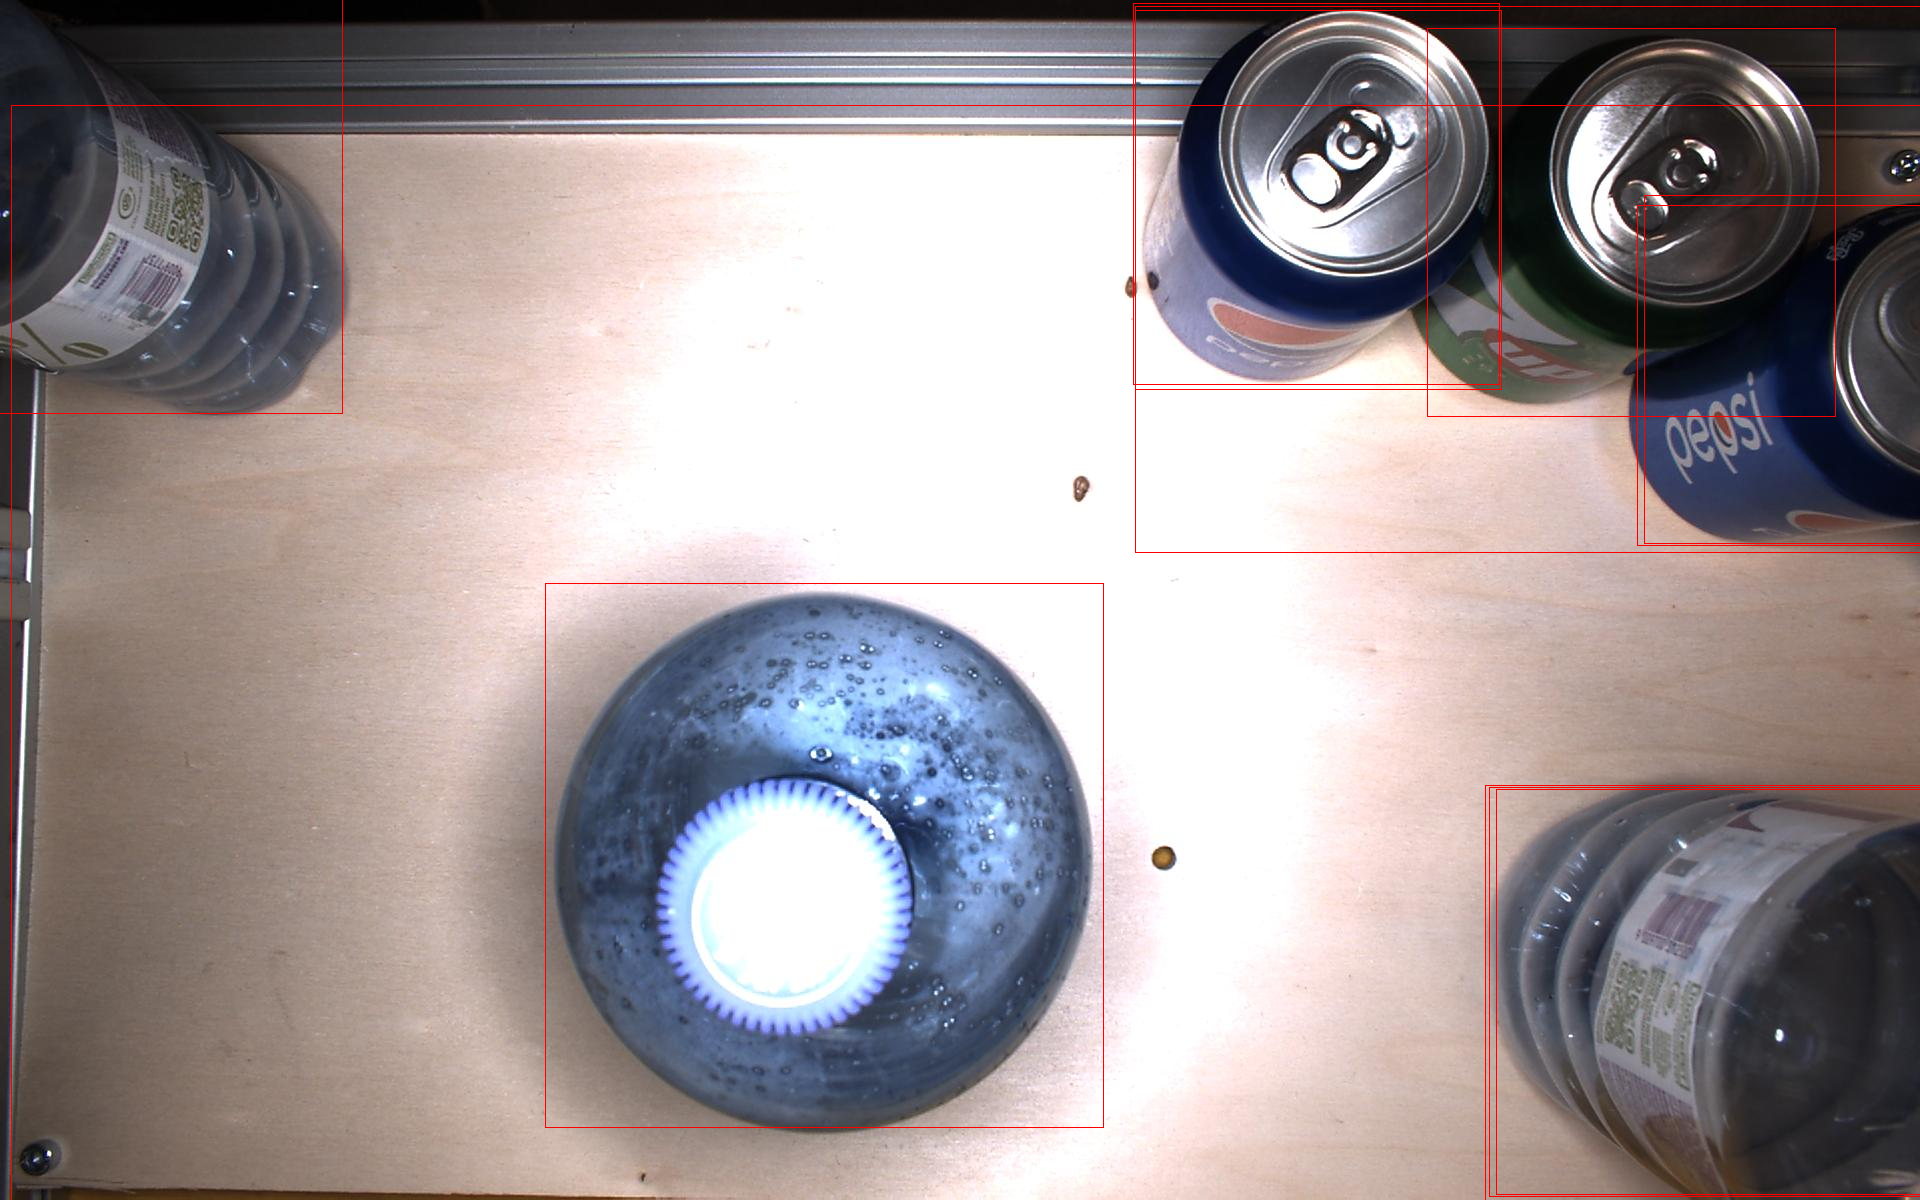

In [99]:
image_path = images[n-1]

# Load image
image = Image.open(image_path).convert("RGB")

# visualize results with pillow
draw = ImageDraw.Draw(image)
bounding_boxes = boxes_filtered#boxes[nms_out]
for i in range(len(bounding_boxes)):
    draw.rectangle(((bounding_boxes[i][0], bounding_boxes[i][1]), (bounding_boxes[i][2], bounding_boxes[i][3])), outline="red")
image.show()